RF data shape: (128, 2048)  →  128 beams × 2048 samples
Bandpass filter: 2.10 – 3.90 MHz


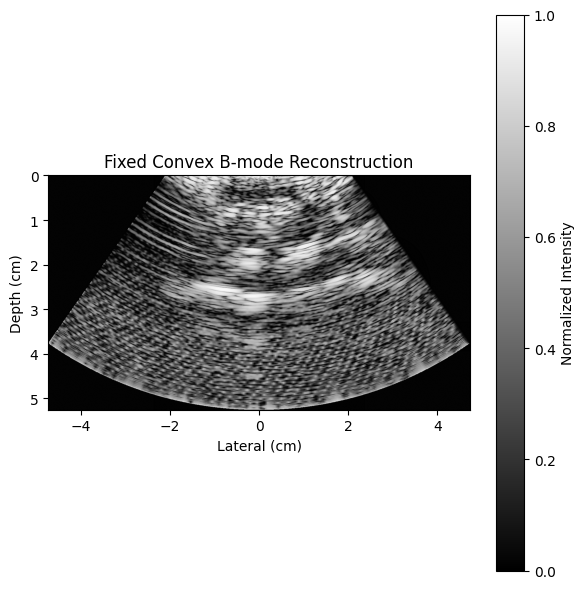

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, butter, filtfilt
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import gaussian_filter
import cv2


def anisotropic_diffusion(img, niter=5, kappa=30, gamma=0.1):
    """
    Perona-Malik anisotropic diffusion for edge-preserving speckle reduction.
    """
    img = img.astype(np.float32)
    for _ in range(niter):
        nablaN = np.roll(img, -1, axis=0) - img
        nablaS = np.roll(img,  1, axis=0) - img
        nablaE = np.roll(img, -1, axis=1) - img
        nablaW = np.roll(img,  1, axis=1) - img

        cN = np.exp(-(nablaN / kappa) ** 2)
        cS = np.exp(-(nablaS / kappa) ** 2)
        cE = np.exp(-(nablaE / kappa) ** 2)
        cW = np.exp(-(nablaW / kappa) ** 2)

        img += gamma * (cN * nablaN + cS * nablaS + cE * nablaE + cW * nablaW)
    return img


def rf_to_convex_bmode_fixed(
    filepath,
    center_freq=3e6,          # Probe center frequency in Hz — ADJUST TO YOUR PROBE
    fractional_bw=0.6,        # Fractional bandwidth of the bandpass filter
    sector_angle_deg=70,
    curvature_radius_mm=30,
    dynamic_range=60,
    tgc_exponent=1.5,
    output_resolution=(800, 800),
    fs=30e6,
    c=1540,
):
    # -------------------------
    # 1) Load RF Data
    # -------------------------
    data = np.genfromtxt(filepath, delimiter=",", filling_values=0.0)
    if data.ndim == 1:
        data = data[np.newaxis, :]
    if data.shape[1] < data.shape[0]:
        data = data.T  # Ensure shape is (num_beams, num_samples)

    num_beams, num_samples = data.shape
    print(f"RF data shape: {data.shape}  →  {num_beams} beams × {num_samples} samples")

    # -------------------------
    # FIX #10: Bandpass filter around probe center frequency
    # -------------------------
    low  = (center_freq * (1 - fractional_bw / 2)) / (fs / 2)
    high = (center_freq * (1 + fractional_bw / 2)) / (fs / 2)
    low  = np.clip(low,  1e-4, 0.9999)
    high = np.clip(high, 1e-4, 0.9999)
    b, a = butter(4, [low, high], btype="band")
    data = filtfilt(b, a, data, axis=1)
    print(f"Bandpass filter: {low*(fs/2)/1e6:.2f} – {high*(fs/2)/1e6:.2f} MHz")

    # -------------------------
    # 2) Envelope detection
    # -------------------------
    analytic = hilbert(data, axis=1)   # FIX #6: axis=1 = fast-time (samples) axis
    envelope = np.abs(analytic)

    # -------------------------
    # FIX #3: TGC applied to LINEAR envelope BEFORE log compression
    # -------------------------
    depths_idx = np.arange(num_samples)
    tgc = (depths_idx / depths_idx[-1]) ** tgc_exponent + 1.0
    envelope *= tgc[np.newaxis, :]
    envelope /= np.max(envelope) + 1e-12

    # Log compression
    bmode = 20 * np.log10(envelope + 1e-6)

    # FIX #9: Clip to dynamic range AFTER TGC
    bmode = np.clip(bmode, -dynamic_range, 0.0)
    bmode = (bmode + dynamic_range) / dynamic_range  # Normalize to [0, 1]

    # -------------------------
    # 3) Light pre-filter (before scan conversion)
    # -------------------------
    bmode = gaussian_filter(bmode, sigma=0.5)

    # -------------------------
    # FIX #1 + #2: Correct convex scan conversion geometry
    # -------------------------
    sector_angle = np.deg2rad(sector_angle_deg)
    dr = c / (2 * fs)
    depths_m = np.arange(num_samples) * dr
    Rcurv = curvature_radius_mm / 1000.0

    theta = np.linspace(-sector_angle / 2, sector_angle / 2, num_beams)

    # Correct formula: each sample is at radius (Rcurv + depth) from the probe origin,
    # along angle theta. The probe face is at y=0; depth increases downward.
    #
    #   X = (Rcurv + depth) * sin(theta)
    #   Y = (Rcurv + depth) * cos(theta) - Rcurv
    #
    # This places the probe face (depth=0) at Y=0 for all beams, with depth going down.
    r = Rcurv + depths_m                             # shape: (num_samples,)
    Xp = r[None, :] * np.sin(theta)[:, None]         # shape: (num_beams, num_samples)
    Yp = r[None, :] * np.cos(theta)[:, None] - Rcurv # shape: (num_beams, num_samples)

    # -------------------------
    max_depth = depths_m[-1]
    x_max = (Rcurv + max_depth) * np.sin(sector_angle / 2)

    x_lin = np.linspace(-x_max, x_max, output_resolution[1])
    y_lin = np.linspace(0, max_depth, output_resolution[0])
    Xg, Yg = np.meshgrid(x_lin, y_lin)

    # Convert Cartesian grid to polar (theta, r) for interpolation
    r_grid     = np.sqrt(Xg ** 2 + (Yg + Rcurv) ** 2)
    theta_grid = np.arctan2(Xg, Yg + Rcurv)

    # Interpolate on the regular (theta, depth) grid
    interp = RegularGridInterpolator(
        (theta, depths_m),
        bmode,
        method="linear",
        bounds_error=False,
        fill_value=0.0,
    )
    query_pts = np.column_stack((theta_grid.ravel(), r_grid.ravel() - Rcurv))
    cart = interp(query_pts).reshape(output_resolution)

    # -------------------------
    # FIX #4: Vectorized sector mask (fast + geometrically correct)
    # -------------------------
    mask = (
        (np.abs(theta_grid) <= sector_angle / 2) &
        (r_grid >= Rcurv) &
        (r_grid <= Rcurv + max_depth)
    )
    cart_masked = np.where(mask, cart, 0.0)

    # -------------------------
    img8 = np.clip(cart_masked * 255, 0, 255).astype(np.uint8)

    # Anisotropic diffusion for speckle reduction
    img_diff = anisotropic_diffusion(img8, niter=5, kappa=30, gamma=0.1)

    # FIX #5: Clip to [0,255] BEFORE casting to uint8 to avoid wrap-around artifacts
    img_diff_clipped = np.clip(img_diff, 0, 255).astype(np.uint8)

    # CLAHE for local contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_diff_clipped)

    # Mild sharpening
    kernel_sharp = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img_sharp = cv2.filter2D(img_clahe, -1, kernel_sharp)

    final_img = img_sharp.astype(np.float32) / 255.0

    # -------------------------
    # 7) Display
    # -------------------------
    plt.figure(figsize=(6, 6))
    plt.imshow(
        final_img,
        cmap="gray",
        origin="upper",
        extent=[
            x_lin[0]  * 100,
            x_lin[-1] * 100,
            y_lin[-1] * 100,
            y_lin[0]  * 100,
        ],
    )
    plt.xlabel("Lateral (cm)")
    plt.ylabel("Depth (cm)")
    plt.title("Fixed Convex B-mode Reconstruction")
    plt.colorbar(label="Normalized Intensity")
    plt.tight_layout()
    plt.show()

    return final_img


# -------------------------
# Run
# -------------------------
img = rf_to_convex_bmode_fixed(
    "ae2RF.txt",
    center_freq=3e6,           # <-- SET THIS to your probe's center frequency
    fractional_bw=0.6,
    sector_angle_deg=70,
    curvature_radius_mm=30,
)